In [2]:
!git clone https://github.com/ultralytics/yolov5 #скачиваем йоло5
!nvidia-smi
%cd zero-shot-object-tracking
%cd yolov5
%pip install -qr requirements.txt
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

#импортируем необходимые библиотеки
from glob import glob
import torch
import utils
import cv2
from sklearn.metrics import mean_squared_error as mse
from PIL import Image
import random
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from keras.preprocessing import image
import zipfile
from google.colab import drive
import os
HOME = os.getcwd()
print(HOME)


Ultralytics YOLOv8.0.184 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


/content/yolov5


In [16]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/drive/MyDrive/123.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [17]:
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/test1.mp4"

In [3]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [4]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [5]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [6]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [7]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [8]:
# settings
MODEL = "yolov8n.pt"
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 6.23M/6.23M [00:00<00:00, 68.4MB/s]
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs



0: 384x640 1 train, 38.6ms
Speed: 2.6ms preprocess, 38.6ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


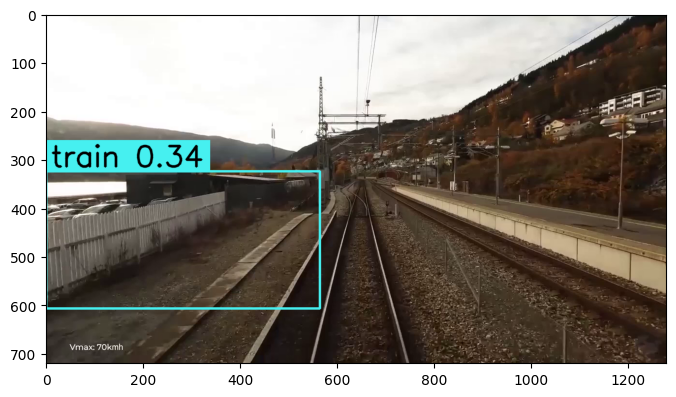

In [18]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
CLASS_ID = [0]
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (8, 8))

In [19]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = "/content/drive/MyDrive/123.mp4"
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=30, total_frames=1163)

In [31]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)
fps_out = 1
index_in = -1
index_out = -1
fps_in = 25
# df = pd.DataFrame(), columns=['filename', 'cases_count', 'timestamps']
# df.to_csv('submission.csv', index=False)
# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        index_in += 1
        out_due = int(index_in / fps_in * fps_out)
        if out_due > index_out:
          index_out += 1
          results = model(frame)
          detections = Detections(
              xyxy=results[0].boxes.xyxy.cpu().numpy(),
              confidence=results[0].boxes.conf.cpu().numpy(),
              class_id=results[0].boxes.cls.cpu().numpy().astype(int)
          )
          # filtering out detections with unwanted classes
          mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
          detections.filter(mask=mask, inplace=True)
          # tracking detections
          tracks = byte_tracker.update(
              output_results=detections2boxes(detections=detections),
              img_info=frame.shape,
              img_size=frame.shape
          )
          tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
          detections.tracker_id = np.array(tracker_id)
          # filtering out detections without trackers
          mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
          detections.filter(mask=mask, inplace=True)
          # format custom labels
          labels = [
              f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
              for _, confidence, class_id, tracker_id
              in detections
          ]
          # updating line counter
          line_counter.update(detections=detections)
          # annotate and display frame
          frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
          line_annotator.annotate(frame=frame, line_counter=line_counter)

          xyxy=results[0].boxes.xyxy.cpu().numpy()
          if len(xyxy)> 4 and xyxy[0]<800 and xyxy[2]>600:
              print(frame.size())
              data = np.array(im)
              r1, g1, b1 = 0, 0, 0 # Original value
              r2, g2, b2 = 255, 255, 255 # Value that we want to replace it with
              red, green, blue = data[:,:,0], data[:,:,1], data[:,:,2]
              mask = (red == r1) & (green == g1) & (blue == b1)
              data[:,:,:3][mask] = [r2, g2, b2]
              im = Image.fromarray(data)
          sink.write_frame(frame)


  0%|          | 0/1163 [00:00<?, ?it/s]


0: 384x640 1 train, 19.3ms
Speed: 2.3ms preprocess, 19.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 17.5ms
Speed: 4.8ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 33.7ms
Speed: 4.0ms preprocess, 33.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 19.7ms
Speed: 2.1ms preprocess, 19.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.4ms
Speed: 9.2ms preprocess, 12.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 16.6ms
Speed: 4.7ms preprocess, 16.6ms inference, 9.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 38.6ms
Speed: 2.5ms preprocess, 38.6ms inference, 1.3ms po

In [ ]:
def bezier_curve(points, ntimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1],
                 [2,3],
                 [4,5], ..[Xn, Yn] ]
        ntimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    def bernstein_poly(i, n, t):
        """
         The Bernstein polynomial of n, i as a function of t
        """
        return comb(n, i) * (t ** (n - i)) * (1 - t) ** i

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, ntimes)

    polynomial_array = np.array([bernstein_poly(i, nPoints - 1, t) for i in range(0, nPoints)])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)
    return xvals.astype('int32'), yvals.astype('int32')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')